In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import re
from datetime import datetime
import qmnet_model as qnm
import qmnet_tools as qnt
import qmnet_train as qntrain
import tensorflow as tf
from IPython.core.debugger import Tracer

%matplotlib inline

clear_output()

In [8]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
basis = 'cc-pvdz'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 30000

In [9]:
molstr_list = [
    # 1 occ state, 2 electrons
    'HH',
#     'HHe+',
#     # 2 occ state, 4 electrons
#     'HLi',
#     'HBe+',
#     'HeHe',
#     'HeLi+',
#     # 3 occ state, 6 electrons
#     'HeBe',
#     'LiLi',
#     'LiBe+',
#     # 4 occ state, 8 electrons
#     'BeBe',
]

In [10]:
inp_grp = []
#inp_dump = []
for molstr in molstr_list:
    if '+' in molstr:
        charge = 1
    elif '-' in molstr:
        charge = -1
    else:
        charge = 0
    alist = re.findall('[A-Z][a-z]*', molstr)
    Zs = [qtk.n2Z(a) for a in alist]
    inp_list = []
    inp_grp.append(inp_list)
    #inp_dump.append(inp_list)
    res = resolution
    for R in np.arange(0.3, 4.0 + res, res):
        mol = qtk.Molecule()
        ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
        mol.build(ZR)
        mol.charge = charge
        mol.name = mol.name + '_%s' % str(R)
        inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
        try:
            inp.run()
            D, U = np.linalg.eigh(inp.olp)
            inp.X = U / np.sqrt(D)
            
            # to save inps into pickle file
            #inp.delete_ht_types()
            #inp.delete_matrices()
            
            inp_list.append(inp)
        except:
            pass
    print "%s finished" % mol.name
print [len(inp) for inp in inp_grp]

H2_4.0 finished
[741]


In [5]:
def get_C_prd(qmnet_model, model_file_name, inp_in):
    I_list, Er_list, occ_list, nn_list, C_list, y_list = qnt.tfIO_batch(inp_in, 100)
    
    tf.reset_default_graph()
    g = tf.Graph()

    with g.as_default():
        y_prd, C_prd, param = qmnet_model(g, I_list[0][0].shape[-1])
        I, Er, occ, nn, keep_prob = param
        #y_prd = qnl.HF_energy_layer(I, Er, occ, nn, C_prd)
        
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, model_file_name)
            C_out_list, y_out_list = [], []
            for I_v, Er_v, occ_v, nn_v in zip(I_list, Er_list, occ_list, nn_list):
                valid_dict = {I:I_v, Er:Er_v, occ:occ_v, nn:nn_v, keep_prob:1.0}
                C_out, y_out = sess.run([C_prd, y_prd], feed_dict=valid_dict)
                C_out_list.extend(C_out)
                y_out_list.extend(y_out)
            
            return C_out_list, y_out_list

In [6]:
inp = inp_grp[0][5]
I_np, Er_np, occ, nn = qnt.get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
print qnt.get_output(I_np, Er_np, occ, nn, C)
print inp.Et

-0.730430578246
-0.730430578246


In [13]:
lr = 0.001
const_lr = {
    'learn_rate_start':0.1, 
    'learn_rate_min':lr, 
    'learn_rate_base':1.0, 
}
vary_lr_H2 = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.000001, 
    'learn_rate_steps':100, 
    'learn_rate_base':0.8
}

vary_lr_LiH = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.00005, 
    'learn_rate_steps':300, 
    'learn_rate_base':0.8
}

vary_lr = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.00005, 
    'learn_rate_steps':500, 
    'learn_rate_base':0.8
}

reload(qnt)
reload(qnm)
reload(qnm.qnl)
reload(qntrain)
reload(qntrain.qnt)
train = qntrain.train
#qm_model = qnm.I0_S2x5_O1x3
#qm_model = qnm.Ix0_dS5x5_O3x5
#qm_model = qnm.I0_S1x2_d_S1x2_O1x3
#qm_model = qnm.I3_S3O3x5d_S3O3x5_O3x3
#qm_model = qnm.I3_S5x10_d_S5x5_dS2_O3x5
#qm_model = qnm.Ix3_R5_O2
#qm_model = qnm.Ix3_R5h2b_O2
#qm_model = qnm.Ix3_R3h2b_R5h1b_O2
#qm_model = qnm.I2_R5h2b_d_R3h1b_d_R2h1b_O5
#qm_model = qnm.Fock_error_test
#qm_model = qnm.Ix0_dS5x5_O3x5
#qm_model = qnm.I2_R5h2b_R3h1b_O2

#qm_model = qnm.I0_S1x4_O1_SCFx2
#qm_model = qnm.I0_S1x4_O2_SCFx1
qm_model = qnm.I0_S1x4_O1_SCFx1
#qm_model = qnm.I0_S1x2_d_S1x2_O1x3_SCF

In [14]:
tf.reset_default_graph()

opt_names = [
    ['energy_minimize', 'emin'],
    ['energy', 'energy'],
    ['fock', 'fock'],
]

mol_ind = 0
opt = opt_names[0]

base_setting = {
    'valid_ind': mol_ind,
    'train_list': [mol_ind],
    'threshold': 1E-4,
    'from_scratch': True,
    'batch_size': 16, 
    'print_step': 500,
    'kp': 1.0,
    'save_step': 1000,
    'save_full_valid_Cprd': True,
    'molstr_list': molstr_list,
    'maxiter': 1000,
}
base_setting.update(vary_lr_LiH)
save_name =  '%s_SCF_p_test_%s' % (molstr_list[mol_ind].replace('+',''), opt[1])
train(qm_model, inp_grp, save_name, loss=opt[0], **base_setting)

root name: HH_SCF_p_test_emin
model: <function I0_S1x4_O1_SCFx1 at 0x7fdbbd522b90>
train/test/validation size: 666/75/741 
optimizer: <class 'tensorflow.python.training.adam.AdamOptimizer'>
loss: energy_minimize
reg_scale: 0.0
keep_prob: 1.0
batch size: 16
number of batches: 42
training set: ['HH']
validation: HH
learning rate min: 5e-05
learning rate steps: 300
learning rate start: 0.001
learning rate base: 0.8
print step: 500
history step: 1
threshold: 0.0001
maxiter: 1000
execuate time: 2017/10/17 14:10:06


start from scratch...

epoch:   500 train/test/validatoin error: 0.000027/0.000650/0.000093 at rate 0.000690
epoch:  1000 train/test/validatoin error: 0.000021/0.000826/0.000101 at rate 0.000476
Model and history backup

Model saved in file: HH_SCF_p_test_emin.ckpt

optimization history saved
session and log file closed


In [67]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)
reload(qntrain)
reload(qntrain.qnt)
train = qntrain.train
qm_model = qnm.I0_S1x4_SCFx1

tf.reset_default_graph()

mol_ind = 0
base_setting = {
    'valid_ind': mol_ind,
    'train_list': [mol_ind],
    'threshold': 1E-4,
    'from_scratch': False,
    'batch_size': 16, 
    'print_step': 500,
    'kp': 1.0,
    'save_step': 1000,
    'save_full_valid_Cprd': True,
    'molstr_list': molstr_list,
    'maxiter': 1000,
}
base_setting.update(vary_lr_LiH)

for opt_iter in range(3):
    opt = opt_names[opt_iter]
    save_name =  '%s_S4_SCF_p_%s' % (molstr_list[mol_ind].replace('+',''), opt[1])
    train(qm_model, inp_grp, save_name, loss=opt[0], **base_setting)

root name: HH_S4_SCF_emin
model: <function I0_S1x4_SCFx1 at 0x7f3860da3398>
train/test/validation size: 666/75/741 
optimizer: <class 'tensorflow.python.training.adam.AdamOptimizer'>
loss: energy_minimize
reg_scale: 0.0
keep_prob: 1.0
batch size: 16
number of batches: 42
training set: ['HH']
validation: HH
learning rate min: 5e-05
learning rate steps: 300
learning rate start: 0.001
learning rate base: 0.8
print step: 500
history step: 1
threshold: 0.0001
maxiter: 1000
execuate time: 2017/10/16 16:42:01


INFO:tensorflow:Restoring parameters from HH_S4_SCF_emin.ckpt
no model found, or reload failed, start from scratch

epoch:   500 train/test/validatoin error: 0.012776/0.013658/0.012871 at rate 0.000690
epoch:  1000 train/test/validatoin error: 0.012775/0.013651/0.012864 at rate 0.000476
Model and history backup

Model saved in file: HH_S4_SCF_emin.ckpt

optimization history saved
session and log file closed
root name: HH_S4_SCF_energy
model: <function I0_S1x4_SCFx1 at 0x7f3860da3398>
t

In [47]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)

#mol_ind = 2
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, mol_ind, [mol_ind])
#_, _, inp_dense = qnt.train_test_valid(inp_grp, valid_ind, train_list)

#qm_model = qnm.I0_S1x2_d_S1x2_O1x3_SCF
qm_model = qnm.I0_S1x4_O2_SCFx1
model_root = '%s_SCF_single_test_energy' % molstr_list[mol_ind].replace('+','')
#model_root = '%s_SCF_test' % molstr_list[mol_ind].replace('+','')
#model_root = '%s_SCF_single_test' % molstr_list[mol_ind].replace('+','')
#model_root = '%s_SCF_multiple_test' % molstr_list[mol_ind].replace('+','')
model_file = "%s.ckpt" % model_root
model_hist = "%s_hist.pkl" % model_root

In [48]:
C_tar, E_tar = get_C_prd(qm_model, model_file, inp_train)
C_prd, E_prd = get_C_prd(qm_model, model_file, inp_test)
C_val, E_val = get_C_prd(qm_model, model_file, inp_valid)

# [train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist]
opt_hist = qtk.load(model_hist)
C_hist = np.array(opt_hist[-3])
print 'done'

INFO:tensorflow:Restoring parameters from HH_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_energy.ckpt
INFO:tensorflow:Restoring parameters from HH_SCF_single_test_energy.ckpt
done


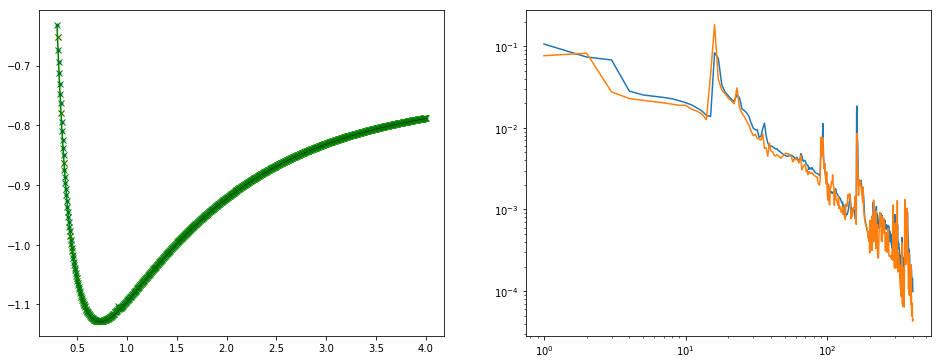

In [49]:
E_true = np.array([inp.Et for inp in inp_train]) 
E_val_true = np.array([inp.Et for inp in inp_valid])
R_tar = np.array([inp.molecule.R[1,0] for inp in inp_train])
R_prd = np.array([inp.molecule.R[1,0] for inp in inp_test])
#R_dense = np.array([inp.molecule.R[1,0] for inp in inp_dense])
R_val = np.array([inp.molecule.R[1,0] for inp in inp_valid])

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,6))
ax1.plot(R_tar, E_tar, ls='', marker='.')
ax1.plot(R_prd, E_prd, ls='', marker='x')
#ax1.plot(R_dense, E_dense, color='g')
ax1.plot(R_val, E_val, color='g', ls='', marker='x')
ax1.plot(R_val, E_val_true, color='g')
ax1.plot(R_tar, E_true, ls='', marker='.', color='k', markersize=0.2)
for i in [0,1]:
    ax2.loglog(opt_hist[i])

In [31]:
def getPsi(inp, C=None, psi_list=None):
    if C is None: C = inp.mov

    mov_back = inp.ht_exp_alpha.coeffs.__array__()
    inp.ht_exp_alpha._coeffs = C

    exp = inp.ht_exp_alpha
    pts = inp.ht_grid.points
    if psi_list is None:
        psi_list = np.array(range(len(inp.occ)))
    psi_list = np.array(psi_list)

    psi = inp.ht_obasis.compute_grid_orbitals_exp(exp, pts, psi_list)

    inp.ht_exp_alpha._coeffs = mov_back

    return psi


def energy(inp, C=None):
    dm = inp.dm(C)
    J_kernel = np.tensordot(dm, inp.er, axes=([0,1], [0,2]))
    X_kernel = np.tensordot(dm, inp.er, axes=([0,1], [0,1]))
    
    Ek = np.trace(dm.dot(inp.kin)) * 2.
    Ev = np.trace(dm.dot(inp.v_ext)) * 2.
    Ej = np.trace(dm.dot(J_kernel)) * 2.
    Ex = np.trace(dm.dot(X_kernel)) * -1.
    nn = inp.ht_external['nn']
    
    return Ek + Ev + Ej + Ex + nn

def fockMatrix(inp, C=None):
    if C is None: C = inp.mov
    F = inp.Fock_matrix(C)
    return F

def eigenvalues(inp, C=None):
    if C is None: C = inp.mov
    F = fockMatrix(inp, C)
    FC = F.dot(C)
    S = inp.olp
    SC = S.dot(C)
    eps = np.diag(FC.T.dot(SC)) / np.diag(SC.T.dot(SC))
    return eps

def fockError(inp, C=None):
    F = fockMatrix(inp, C)
    eps = eigenvalues(inp, C)
    S = inp.olp
    if C is None: C = inp.mov
    res = F.dot(C) - eps * S.dot(C)
    return np.sum(abs(res))

def dmError(inp, C):
    dm_tar = inp.dm()
    dm_prd = inp.dm(C)
    return np.sum(abs(dm_tar - dm_prd))

def dRho(inp, C):
    rho_tar = inp.getRho()
    rho_prd = inp.getRho(inp.dm(C))
    return inp.ht_grid.integrate(np.abs(rho_tar - rho_prd))

def dPsi(inp, C):
    psi_tar = getPsi(inp)
    psi_prd = getPsi(inp, C)
    dpsi = []
    for i in range(len(psi_tar[0])):
        dpsi.append(inp.ht_grid.integrate(np.abs(psi_tar[:,i] - psi_prd[:,i])))
    return np.asarray(dpsi)
    
def learningCurve(property_function, inp_list, C_hist, hist_ind=None, diff=True, **kwargs):
    if diff:
        out_tar = []
        for inp in inp_list:
            out_tar.append(property_function(inp, **kwargs))
        if type(out_tar[0]) is np.ndarray:
            out_tar = np.stack(out_tar)
        else:
            out_tar = np.array(out_tar)
            
    err = []
    nparr = False
    if not hist_ind:
        hist_ind = range(len(C_hist))
    for c in hist_ind:
        Cs = C_hist[c]
        out_prd = []
        for i in range(len(Cs)):
            inp = inp_list[i]
            C = Cs[i]
            out_prd.append(property_function(inp, C, **kwargs))
        if type(out_prd[0]) is np.ndarray:
            out_prd = np.stack(out_prd)
            nparr = True
            axis=0
        else:
            out_prd = np.array(out_prd)
            axis=None
        if diff:
            err.append(np.abs(out_tar-out_prd).mean(axis=axis))
        else:
            err.append(out_prd.mean(axis=axis))
    if nparr:
        err = np.stack(err)
    return err

In [32]:
C_start = C_hist[1]
C_mid = C_hist[50]
C_end = C_hist[-1]

E_prd_start = []
E_prd_mid = []
E_prd_end = []
for i in range(len(inp_valid)):
    inp = inp_valid[i]
    Cs = C_start[i]
    Cm = C_mid[i]
    Ce = C_end[i]
    E_prd_start.append(energy(inp, Cs))
    E_prd_mid.append(energy(inp, Cm))
    E_prd_end.append(energy(inp, Ce))
    
E_prd_start = np.array(E_prd_start)
E_prd_mid = np.array(E_prd_mid)
E_prd_end = np.array(E_prd_end)

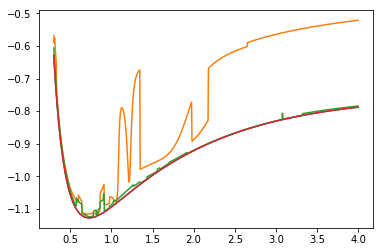

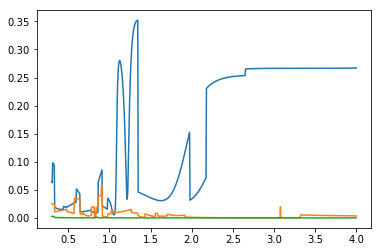

In [33]:
plt.plot(R_val, E_val_true)
plt.plot(R_val, E_prd_start)
plt.plot(R_val, E_prd_mid)
plt.plot(R_val, E_prd_end)

fig = plt.figure()


plt.plot(R_val, abs(E_prd_start - E_val_true))
plt.plot(R_val, abs(E_prd_mid - E_val_true))
plt.plot(R_val, abs(E_prd_end - E_val_true))

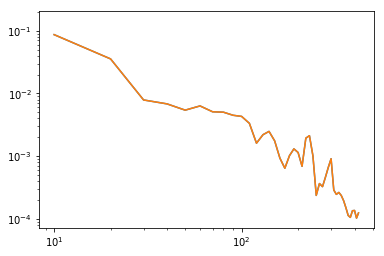

In [35]:
sample_step = 10
hist_x = range(len(opt_hist[2]))[::sample_step]
learn_E = learningCurve(energy, inp_valid, C_hist, hist_ind=hist_x)
plt.loglog(hist_x, learn_E)
plt.loglog(hist_x, opt_hist[2][::sample_step])

In [36]:
learn_eigs = learningCurve(eigenvalues, inp_valid, C_hist, hist_ind=hist_x)

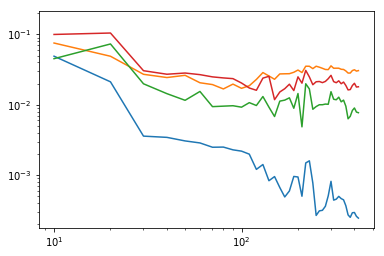

In [37]:
#plt.loglog(hist_x, learn_E)
plt.loglog(hist_x, learn_eigs[:,0])
plt.loglog(hist_x, learn_eigs[:,1])
plt.loglog(hist_x, learn_eigs[:,2])
plt.loglog(hist_x, learn_eigs[:,3])

In [53]:
learn_fe = learningCurve(qna.fockError, inp_valid, C_hist, hist_ind=hist_x)

NameError: name 'qna' is not defined

In [ ]:
plt.loglog(hist_x, learn_fe)

In [223]:
learn_dme = learningCurve(dmError, inp_valid, C_hist, hist_ind=hist_x, diff=False)

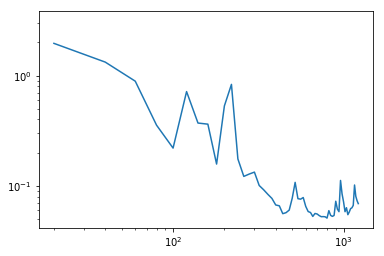

In [224]:
plt.loglog(hist_x, learn_dme)

In [225]:
#learn_fe = learningCurve(fockError, inp_valid, C_hist, hist_ind=hist_x)
learn_drho = learningCurve(dRho, inp_valid, C_hist, hist_ind=hist_x, diff=False)

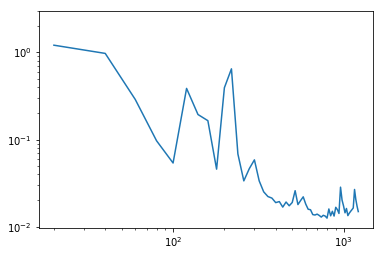

In [226]:
plt.loglog(hist_x, learn_drho)

In [279]:
learn_dpsi = learningCurve(dPsi, inp_valid, C_hist, hist_ind=hist_x, diff=False)

In [280]:
learn_dpsi.shape

(62, 4)

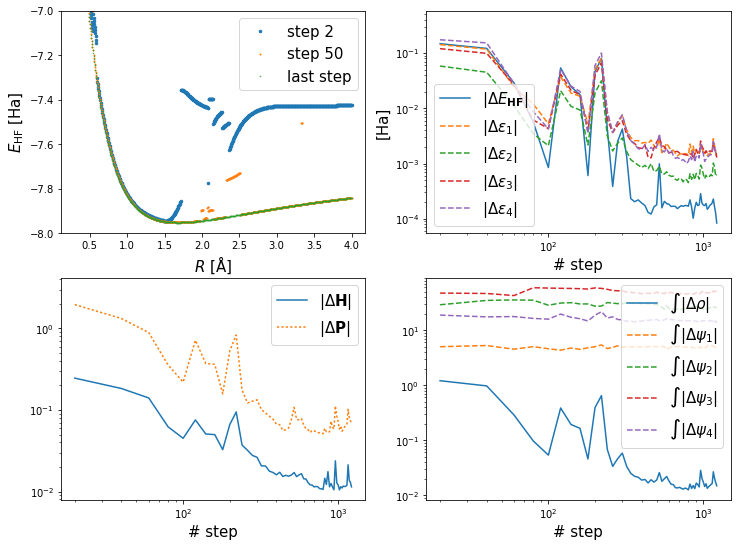

In [299]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(12,9))

ax1.plot(R_val, E_prd_start, ls='', marker='.', ms=5, label='step 2')
ax1.plot(R_val, E_prd_mid, ls='', marker='.', ms=2, label='step 50')
ax1.plot(R_val, E_prd_end, ls='', marker='.', ms=1, label='last step')
ax1.set_ylim(-8,-7)
ax1.legend(fontsize=15)

ax2.loglog(hist_x, learn_E, label=r'|$\Delta E_{\mathbf{HF}}|$')
for i in range(4):
    ax2.loglog(hist_x, learn_eigs[:,i], ls='--', label=r'$|\Delta\varepsilon_%d|$' % (i+1))
ax2.legend(fontsize=15)

ax4.loglog(hist_x, learn_drho, label=r'$\int|\Delta\rho|$')
for i in range(4):
    ax4.loglog(hist_x, learn_dpsi[:,i], ls='--', label=r'$\int|\Delta\psi_%d|$' % (i+1))
ax4.legend(loc=1, fontsize=15)

ax3.loglog(hist_x, learn_fe, label=r'$|\Delta\mathbf{H}|$')
ax3.loglog(hist_x, learn_dme, ls=':', label=r'$|\Delta\mathbf{P}|$')
ax3.legend(fontsize=15)

ax1.set_xlabel(r'$R$ [$\mathrm{\AA}$]', fontsize=15)
ax2.set_xlabel('# step', fontsize=15)
ax3.set_xlabel('# step', fontsize=15)
ax4.set_xlabel('# step', fontsize=15)

ax1.set_ylabel(r'$E_{\mathrm{HF}}$ [Ha]', fontsize=15)
ax2.set_ylabel(r'[Ha]', fontsize=15)

In [292]:
inp_ind = 10
inp = inp_valid[inp_ind]
print inp.Fock_matrix(inp.X.dot(C_hist[-1][inp_ind]))
print inp.Fock_matrix()

[[-0.61186236 -0.35267072 -0.72018603 -0.34578506]
 [-0.35267072 -0.17703553 -0.35134592 -0.17947247]
 [-0.72018603 -0.35134592 -0.57849306 -0.34607623]
 [-0.34578506 -0.17947247 -0.34607623 -0.17735249]]
[[-0.62918976 -0.5069882  -0.79172292 -0.5103871 ]
 [-0.5069882  -0.20598008 -0.5103871  -0.21068854]
 [-0.79172292 -0.5103871  -0.62918976 -0.5069882 ]
 [-0.5103871  -0.21068854 -0.5069882  -0.20598008]]


In [283]:
# Pure SCF test

reload(qnm)
reload(qnm.qnl)

qmnet_model = qnm.HF_iter_20

inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, 0, range(len(molstr_list)))
I_train, Er_train, occ_train, nn_train, C_train, y_train = qnt.tfIO_batch(inp_train, 16)
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    y = tf.placeholder(tf.float64, name='y')
    y_prd, C_prd, param = qmnet_model(g, inp_valid[0].olp.shape[0])
    I, Er, occ, nn, keep_prob = param
    with tf.Session() as sess:
        #sess.run(tf.global_variables_initializer())
        for I_b, Er_b, occ_b, nn_b, C_b, y_b in \
        zip(I_train, Er_train, occ_train, nn_train, C_train, y_train)[:5]:
            train_dict = {I:I_b, Er:Er_b, occ:occ_b, nn:nn_b, y:y_b, keep_prob:1}
            y_prd_b = sess.run(y_prd, feed_dict=train_dict)
            print y_prd_b - y_b

[ -1.40332190e-12  -2.54907206e-12  -5.33839639e-12   0.00000000e+00
  -4.22062385e-12  -1.34114941e-12  -2.41584530e-13  -1.84741111e-13
  -5.89750471e-13  -5.32907052e-13  -1.52056145e-12  -2.24176233e-12
  -1.08979492e-12  -8.35598257e-12  -1.06581410e-13   7.10542736e-15]
[ -1.04805054e-13  -1.35003120e-12  -1.24700250e-12  -5.02708986e-13
  -2.41584530e-12  -6.35935749e-12  -1.25055521e-12  -8.09308176e-12
  -6.39843734e-12  -1.94333438e-12  -1.93978167e-12  -4.03233003e-13
  -9.55679980e-13  -5.43920464e-12  -2.18491891e-13  -2.27018404e-12]
[ -1.19371180e-12  -1.30739863e-12  -1.58095759e-12  -2.06057393e-12
  -2.17603713e-13  -1.44808610e-11  -1.99840144e-13   1.06581410e-14
  -1.42108547e-14  -8.13571432e-13  -6.60804744e-13  -1.17239551e-13
  -2.11031193e-12  -3.44879680e-12   0.00000000e+00  -3.02335934e-12]
[ -7.85149723e-13  -4.28101998e-13  -1.82254212e-12  -2.62900812e-13
  -3.19433369e-12  -3.30402372e-12  -9.23705556e-14  -7.01749769e-12
  -7.53175300e-13  -5.79092330e